In [43]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Clean Data

In [23]:
# Initiaize DataFrame
df = pd.read_csv("Customer_Churn.csv")

# Print data types for each column
column_dtypes = df.dtypes
print(column_dtypes)
print()

# Check for missing values
missing_values = df.isnull().sum().sum()
print(f"Total Missing Values {missing_values}") # There are no missing values

# Convert TotalCharges column to numerical format
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Fill missing values with median
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Duplicate Rows: {duplicate_rows}") # There are no duplicate rows

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Total Missing Values 0
Duplicate Rows: 0


# EDA

C:\Users\LESEGO\AppData\Local\Temp\ipykernel_28540\2464410174.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"Yes":1, "No":0, "No internet service":0, "No phone service":0})


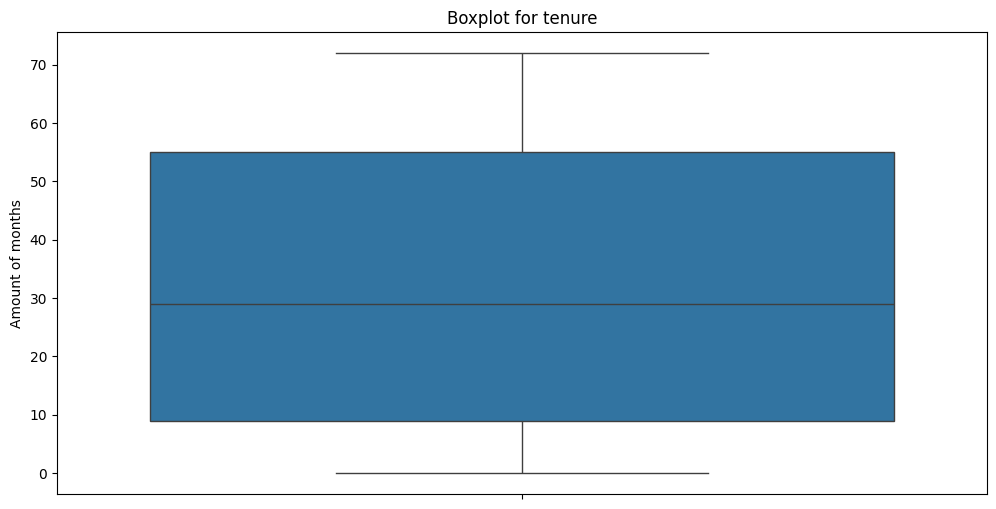

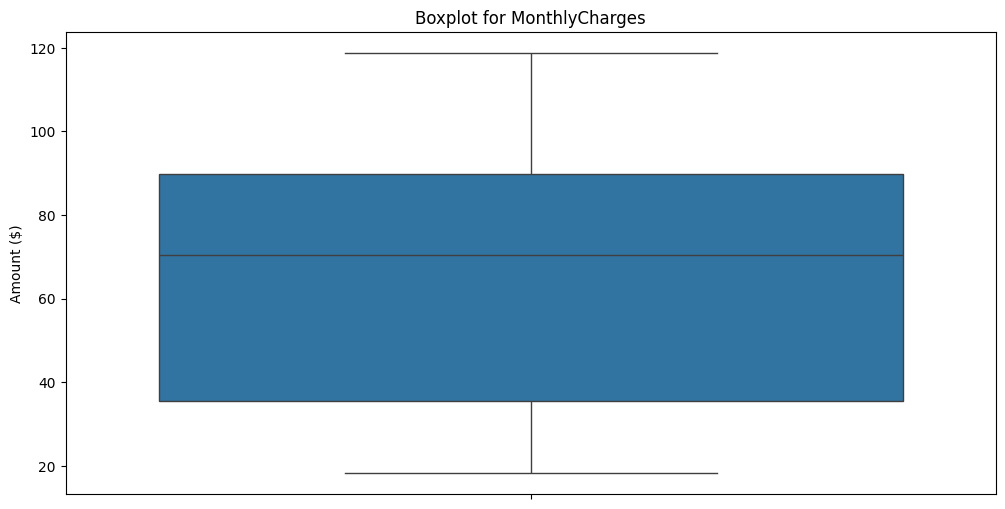

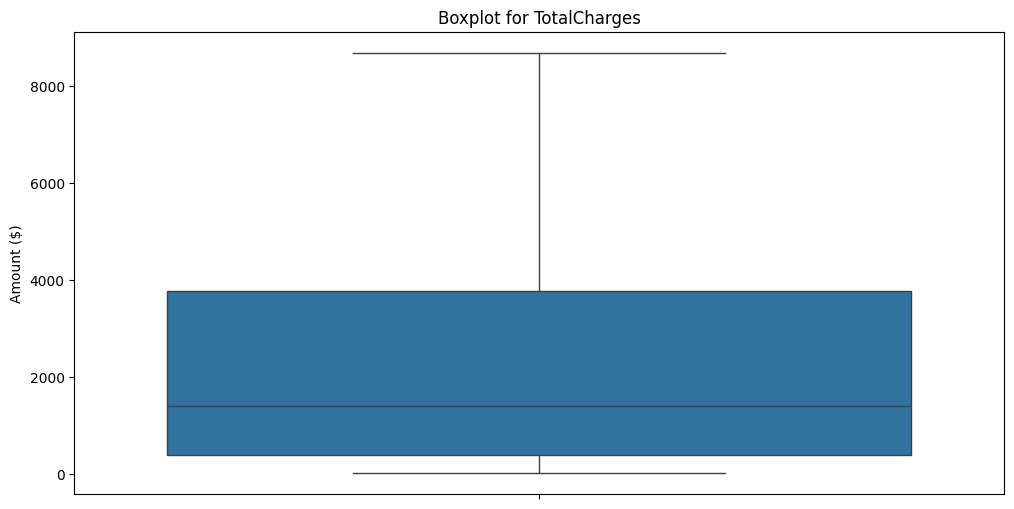

In [24]:
# Replaec all yes and no with 1 and 0
df = df.replace({"Yes":1, "No":0, "No internet service":0, "No phone service":0})

# Initialize numerical columns
numerical_columns = [df["tenure"], df["MonthlyCharges"], df["TotalCharges"]]

# Plot boxplot for each
for col in numerical_columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(col)
    plt.title(f"Boxplot for {col.name}")
    
    # Create ylabel for each
    if col.name == df["tenure"].name:
        plt.ylabel("Amount of months")
    else:
        plt.ylabel("Amount ($)")
        
    plt.show() # There are no outliers

# Standardize Dataset

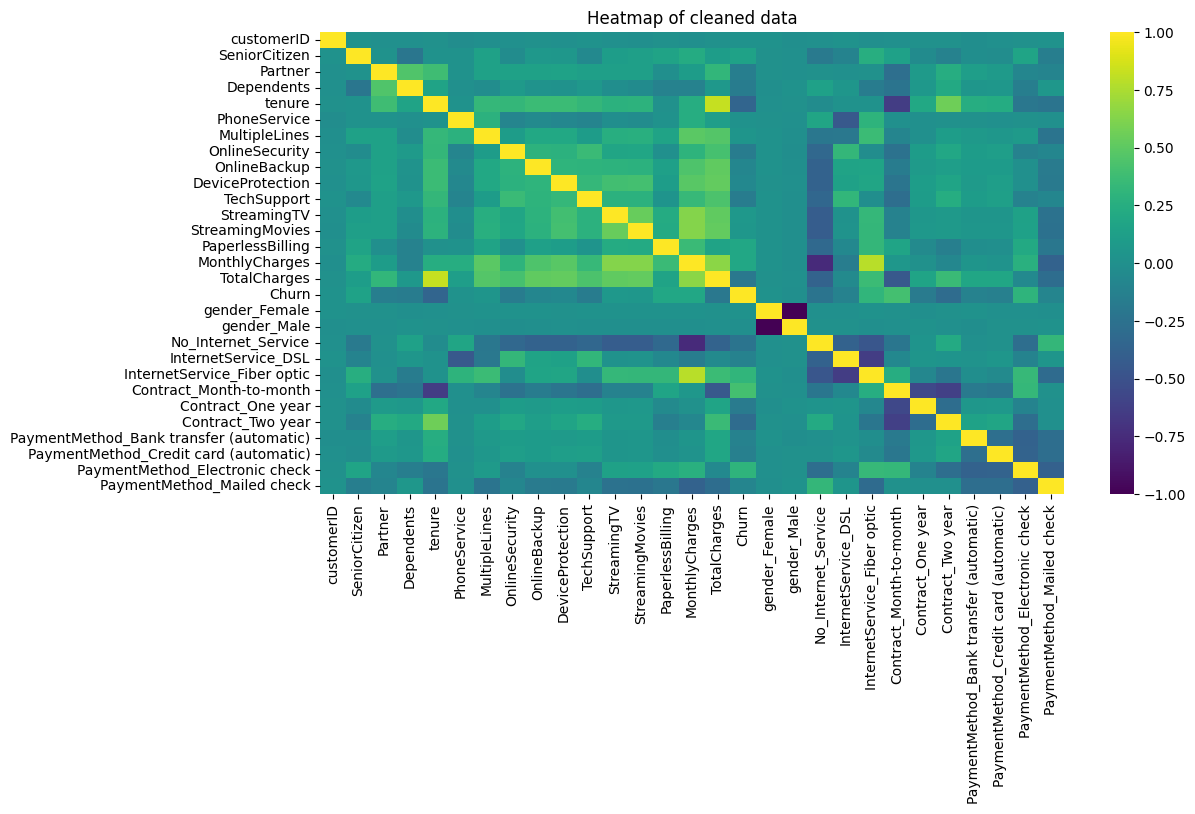

In [25]:
# Replace customerID values with indexes
df["customerID"] = df.index

# One-Hot encode data
df = pd.get_dummies(df)

# Rename column for clarity
df = df.rename(columns={"InternetService_0":"No_Internet_Service"})

# Initialize scaler
scaler = StandardScaler()
# Create new DataFrame with scaled data
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

scaled_df.head()

# Initialize correlation matrix
corr_matrix = scaled_df.corr()

# Heatmap of cleaned data
plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix, cmap="viridis")
plt.title("Heatmap of cleaned data")
plt.show()

# Feature Selection

In [26]:
# Make target column non-numeric (0's and 1's)
scaled_df["Churn"] = scaled_df["Churn"].replace({-0.6010234796064696: 0, 1.6638285090871447: 1})
# Convert target values into int
scaled_df["Churn"] = scaled_df["Churn"].astype(int)

# Initialize features and target
X = scaled_df.drop(columns=["Churn"])
y = scaled_df["Churn"]

# Initialize train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42)

# Create dummy model for feature selection
dummy_model = RandomForestClassifier(random_state=42)
dummy_model.fit(X_train, y_train) # Fit data into model

# Apply feature selection
selector = SelectFromModel(dummy_model)
selector.fit_transform(X_train, y_train) # Fit data into selector

# Selected features
X_test_selected = selector.transform(X_test)

# Hyperparameter Tuning

In [27]:
# Create model
model = RandomForestClassifier(random_state=42)

# Parameter Grid
param_grid = {
    'n_estimators' : [100, 200],
    'criterion' : ["gini", "entropy"],
    'max_depth' : [None, 10],
    "min_samples_split" : [2, 5],
    "min_samples_leaf" : [1, 5],
    "max_features" : ["auto", "sqrt"],
    "bootstrap" : [True, False],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, cv=2, param_grid=param_grid, verbose=2, n_jobs=-1)
# Fit data into GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters for the model
best_params = grid_search.best_params_

print(f"Best parameters for the model: {best_params}")

Fitting 2 folds for each of 128 candidates, totalling 256 fits


C:\Users\LESEGO\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
128 fits failed out of a total of 256.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
123 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LESEGO\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LESEGO\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\LESEGO\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 666, in _validate_params
    

Best parameters for the model: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


# Predict Values and Classification Report

In [48]:
# Initialize model with best parameters
best_rf_clf = grid_search.best_estimator_
best_rf_clf.fit(X_train, y_train)
# Predict the y values
y_test_pred = best_rf_clf.predict(X_test)

# Classification Report
clf_report = classification_report(y_test, y_test_pred)

print(clf_report)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1282
           1       0.68      0.50      0.58       479

    accuracy                           0.80      1761
   macro avg       0.76      0.71      0.72      1761
weighted avg       0.79      0.80      0.79      1761



# Feature Importance Visualization

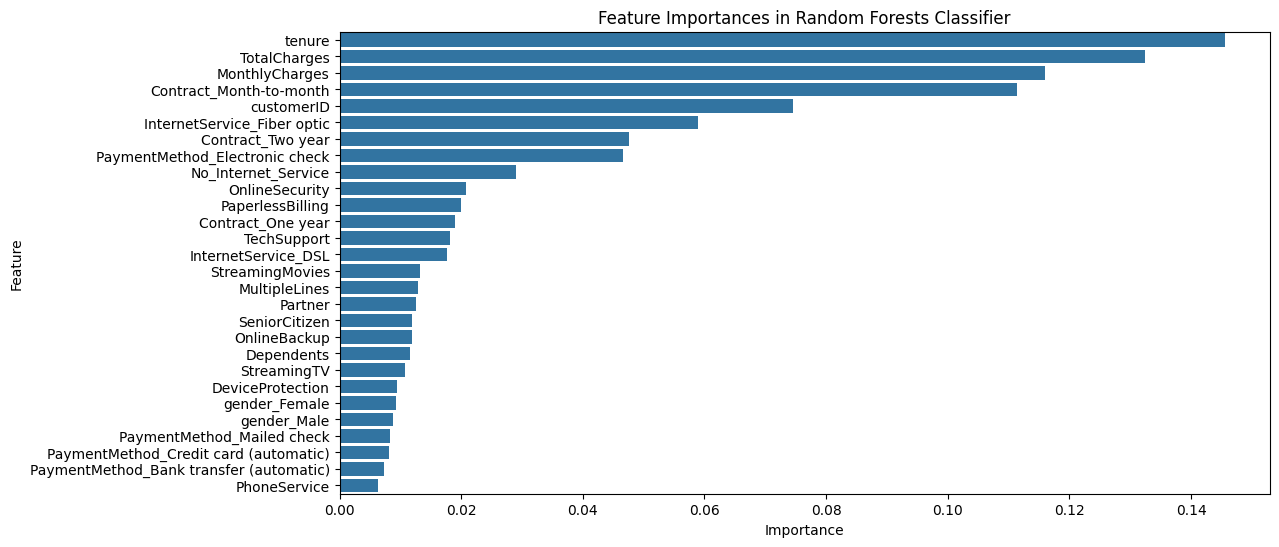

In [41]:
# Get feature importances
feature_importances = pd.Series(best_rf_clf.feature_importances_, index=X_train.columns)
# Sort feature importances
sorted_importances = feature_importances.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.title("Feature Importances in Random Forests Classifier")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()